# 找出距离和方向：反向传播

## 反向传播的定义与价值 

在梯度下降的最初，我们需要先找出坐标点对应的梯度向量。梯度向量是各个自变量求偏导后的表达式再带入坐标点计算出来的，在这一步骤中，最大的难点在于如何获得梯度向量的表达式一一也就是损失函数对各个自变量求偏导后的表达式。在单层神经网络，例如逻辑回归 (二分类单层神经网络)中，我们有如下计算:

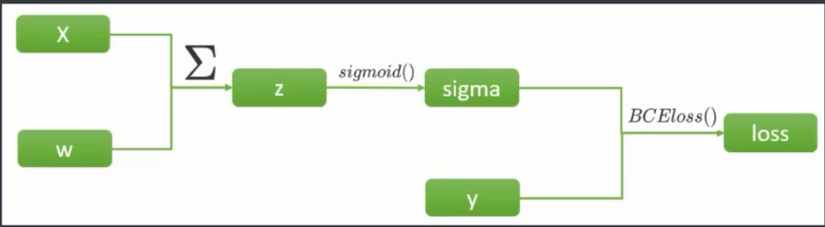

其中BCEloss是二分类交叉熵损失函数。在这个计算图中，从左向右计算以此的过程就是正向传播，因此进行以此计算后，我们会获得所有节点上的张量的值 (z、sigma以及loss)。根据梯度向量的定义，在这个计算过程中我们要求的是损失函数对w的导数，所以求导过程需要涉及到的链路如下:

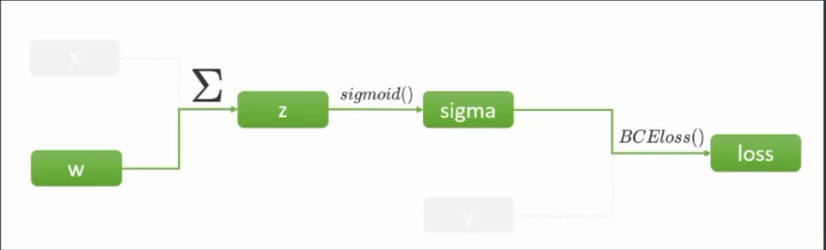

用公式来表示则为在以下式子上求解对w的导数:

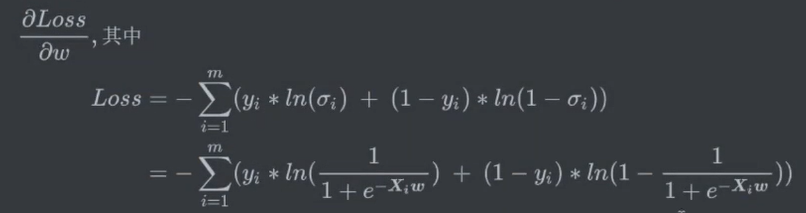

更夸张的是，在双层的、各层激活函数都是sigmoid的二分类神经网络上，我们有如下计算流程:

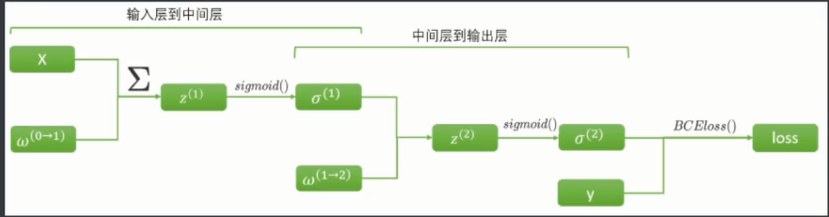

同样的，进行从左到右的正向传播之后，我们会获得所有节点上的张量。其中涉及到的求导链路如下:

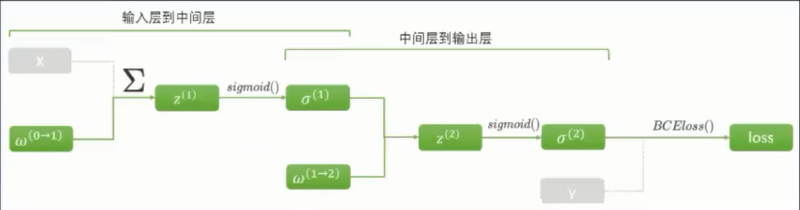

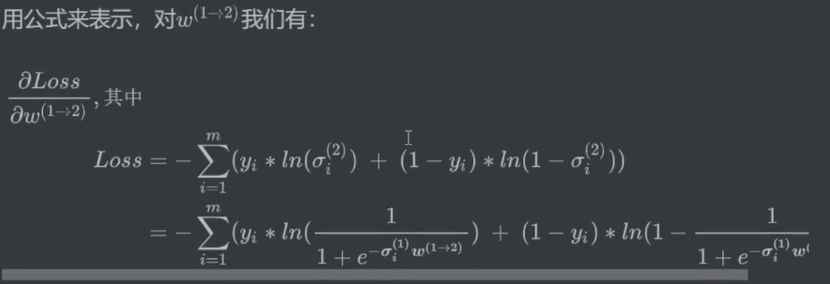

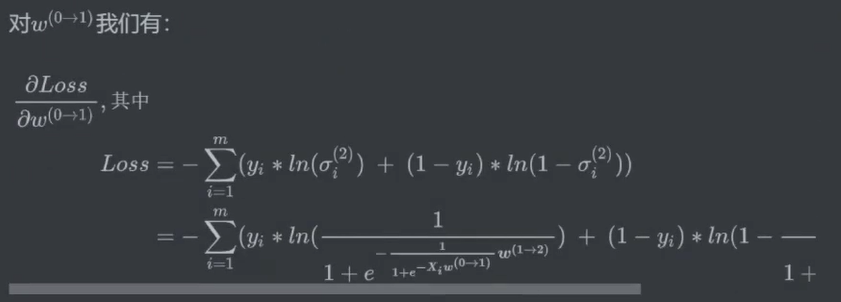

对于需要对这个式子求导，大家感受如何?而这只是一个两层的二分类神经网络，对于复杂神经网络来说，所需要做得求导工作是无法想象的。求导过程的复杂是神经网络历史上的一大难题，这个难题直到1986年才真正被解决。1986年，Rumelhart.Hinton和Williams提出了反向传播算法 (Backpropagation algorithm，又叫做Delta法则)，利用链式法则成功实现了复杂网络求导过程的简单化。 (值得一提的是，多层神经网络解决XOR异或门问题是在1985年被提出的)。接下来，我们就来看看反向传播是怎么解决复杂求导问题的

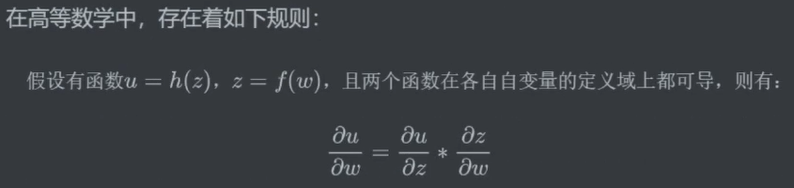

感性(但不严谨)地来说，当一个函数是由多个函数嵌套而成，最外层函数向最内层自变量求导的值，等于外层函数对外层自变量求导的值“内层函数对内层自变量求导的值。这就是链式法则。当函数之间存在复杂的嵌套关系，并且我们需要从最外层的函数向最内层的自变量求导时，链式法则可以让求导过程变得异常简单。

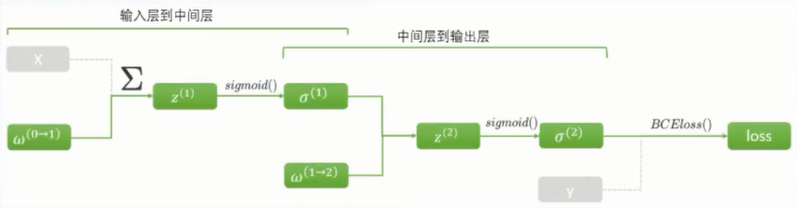

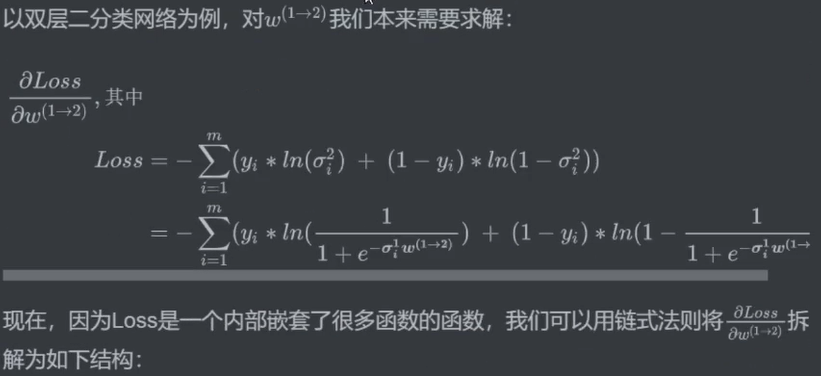

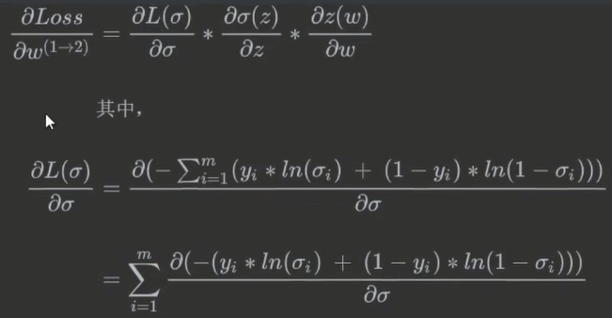

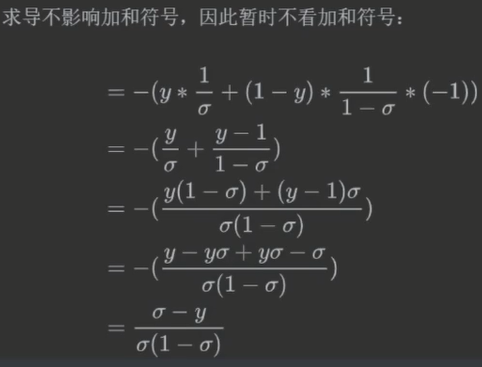

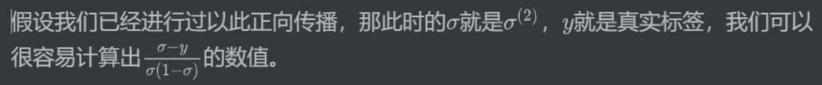

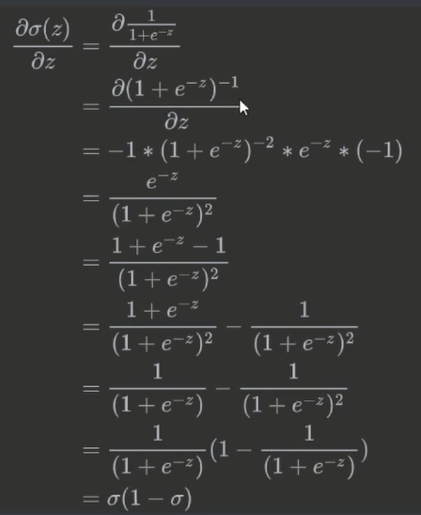

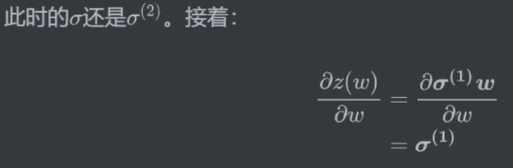

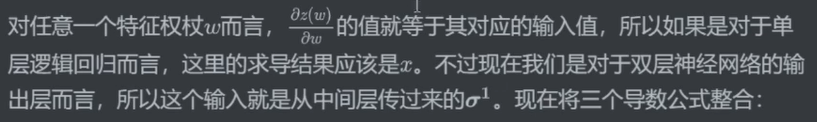

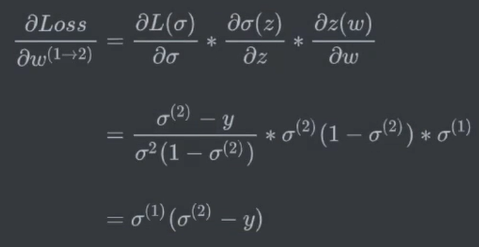

可以发现，将三个偏导数相乘之后，得到的最终的表达式其实非常简单。并且，其中所需要的数据都是我们在正向传播过程中已经计算出来的节点上的张量。同理，我们也可以得到对w(-1)的导数。本来我们需要求解:

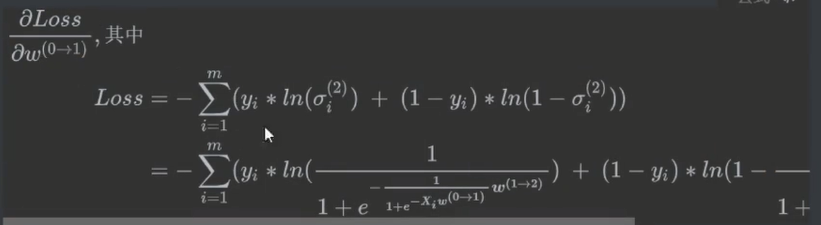

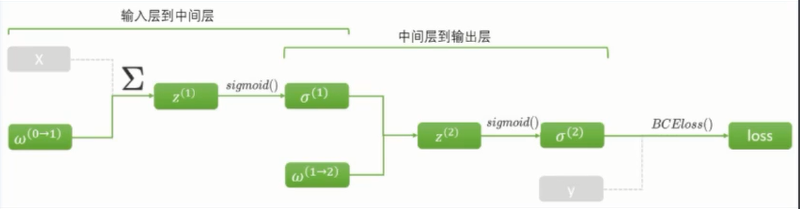

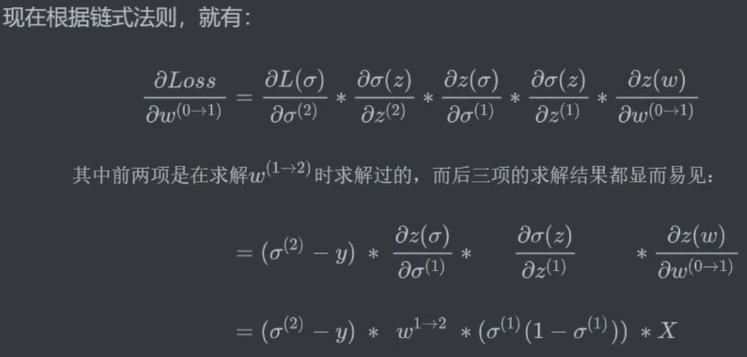

同样，这个表达式现在变得非常简单，并且，这个表达式中所需要的全部张量，都是我们在正向传播中已经计算出来储存好的，或者再模型建立之初就设置好的，因此在计算w(0->1)的导数时，无需再重新计算如σ(2)这样的张量，这就为神经网络计算导数节省了时间。你是否注意到，我们是从左向右，从输出向输入，逐渐往前求解导数的表达式，并且我们所使用的节点上的张量，也是从后向前逐渐用到，这和我们正向传播的过程完全相反。这种从左到右，不断使用正向传播中的元素对梯度向量进行计算的方式，就是反向传播

## PyTorch实现反向传播

在梯度下降中，每走一步都需要更新梯度，所以计算量是巨大的。幸运的是PyTorch可以帮助我们自动计算梯度，我们只需要提取梯度向量的值来进行迭代就可以了。在PyTorch中，我们有两种方式实现梯度计算。一种是使用我们之前已经学过的AutoGrad。在使用AutoGrad时，我们可以使用torch.autograd.grad)函数计算出损失函数上具体某个点/某个变量的导数，当我们需要了解具体某个点的导数值时autograd会非常关键，比如:

In [1]:
import torch

In [17]:
x = torch.tensor(1,requires_grad = True, dtype = torch.float32)
y = torch.tensor(2,requires_grad = True, dtype = torch.float32)
z = x ** 2
sigma = torch.sigmoid(z)
loss = -(y * torch.log(sigma) + (1-y)*torch.log(1-sigma))

In [10]:
torch.autograd.grad(loss,x)

(tensor(-2.5379),)

In [18]:
loss.backward()
x.grad

tensor(-2.5379)

## PyTorch实现多分类反向传播

<li>3分类，500个样本，20个特征，共三层，第一层13个神经元，第二层8个神经元;<br>
<li>第一层激活函数是relu,第二层激活函数是sigmoid

In [20]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [23]:
# 确定数据
# 此时数据没有requires_grad = True
torch.manual_seed(420)
X = torch.rand((500,20),dtype = torch.float32) * 100
y = torch.randint(low = 0,high = 3,size = (500,),dtype = torch.float32)

In [37]:
# 确定神经网络的架构
# LogSoftmax + NLLLoss / CrossEntropyLoss
# BCE,BCEWithLogitLoss
class Model(nn.Module):
    def __init__(self,in_features = 40,out_features = 2):
        super().__init__()
        self.linear1 = nn.Linear(in_features,13,bias=False)
        self.linear2 = nn.Linear(13,8,bias=False)
        self.output = nn.Linear(8,out_features,bias = True)
    
    def forward(self,x):
        sigma1 = torch.relu(self.linear1(x))
        sigma2 = torch.sigmoid(self.linear2(sigma1))
        zhat = self.output(sigma2)
        return zhat

In [38]:
input_ = X.shape[1]
output_ = len(y.unique())

In [51]:
torch.manual_seed(420)
# 实例化神经网络的类
net = Model(in_features=input_,out_features=output_)
zhat = net.forward(X)

In [52]:
# 定义损失函数
criterion = nn.CrossEntropyLoss()

In [53]:
loss = criterion(zhat,y.long())
loss

tensor(1.1559, grad_fn=<NllLossBackward0>)

In [55]:
# 执行反向传播
loss.backward(retain_graph=True) # 保存动态计算图

In [58]:
net.linear1.weight.grad

tensor([[-6.0588e-04, -1.4974e-04, -7.3415e-04, -7.7351e-05, -2.6140e-04,
         -1.1693e-04, -6.6626e-04, -5.1727e-04, -1.8854e-04, -8.5235e-05,
         -1.5836e-04, -3.0359e-04, -1.8416e-04, -6.5027e-04, -2.1789e-04,
         -1.3007e-04, -2.6011e-04, -8.8230e-06, -1.9348e-04, -1.7094e-04],
        [ 2.0197e-02, -1.9837e-03,  2.4011e-02,  2.0821e-03,  1.0392e-02,
          7.1134e-03,  1.2124e-02,  7.9953e-03,  2.9962e-02,  1.8190e-02,
          1.2186e-02,  1.5038e-02,  2.7777e-02,  2.3854e-03,  1.7961e-02,
          1.9643e-02,  3.5274e-02,  2.0755e-02,  3.3556e-03,  1.5672e-03],
        [-2.0935e-02,  1.5948e-02,  6.0700e-03,  1.4997e-02,  8.6461e-03,
          1.9749e-03,  1.8516e-02,  1.2732e-02, -1.1614e-02,  2.3176e-03,
         -5.3246e-03,  1.2712e-02, -5.8676e-03, -8.9849e-03, -1.0081e-02,
          1.6878e-02, -2.0688e-02, -1.7009e-02,  4.2748e-03, -2.4894e-03],
        [-2.6928e-02, -2.1060e-02, -1.6663e-02, -3.1295e-02, -2.4752e-02,
         -3.2839e-02, -1.9562e-02, 

In [61]:
net.linear1.weight.grad.shape

torch.Size([13, 20])

In [62]:
net.linear1.weight.shape

torch.Size([13, 20])

backward求解出的结果的结构与对应的权重矩阵的结构一模一样，因为一个权重就对应了一个偏导数。
这几行代码非常简单，短到几乎不需要去记忆。咋这里，唯一需要说明的点是，在使用autograd的时候，我们强调了requires grad的用法，但在定义打包好的类以及使用loss.backward()的时候，我们却没有给任何数据定义requires_grad=True。这是因为:

1、当使用nn.Module继承后的类进行正向传播时，我们的权重w是自动生成的，在生成时就被自动设置为允许计算梯度 (requires_grad=True) ，所以不需要我们自己去设置

2、同时，观察我们的反向传播过程:

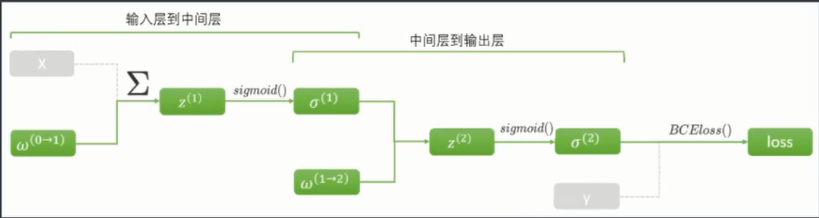

不难发现，我们的特征张量X与真实标签y都不在反向传播的过程当中，但是X与y其实都是损失函数计算需要用的值，在计算图上，这些值都位于叶子节点上，我们在定义损失函数时，并没有告诉损失函数哪些值是自变量，哪些是常数，那backward函数是怎么判断具体求解哪个对象的梯度的呢?

其实就是靠requires_grad。首先backward值会识别叶子节点，不在叶子上的变量是不会被backward考虑的。对于全部叶子节点来说，只有属性requires_grad=True的节点，才会被计算。在设置X与y时，我们都没有写requires_grad参数，也就是默认让“允许求解梯度”这个选项为False，所以backward在计算的时候就只会计算关于w的部分。

当然，我们也可以将X和y或者任何除了权重以及截距的量的requires_grad打开，一旦我们设置为True，packward就会在帮助我们计算w的导数的同时，也棒我们计算以X或y为自变量的导数。在正常的梯度下降和反向传播过程中，我们是不需要这些导数的，因此我们一律不去管requires_grad的设置，就让它默认为False，以节约计算资源。当然，如果你的w是自己设置的，千万记得一定要设置requires_grad=True。